<a href="https://colab.research.google.com/github/lro99/stock_sentiment/blob/main/SentimentTrading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install hf_xet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 MB 13.9 MB/s eta 0:00:00


In [2]:
pip install newsapi-python

In [3]:
pip install finnhub-python

In [4]:
apikey = '62638dc7df5e4e958183e238948a0ebf'

In [5]:
finhubkey = 'd06ltdpr01qg26s8pi6gd06ltdpr01qg26s8pi70'

In [45]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# finBERT
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
# newsapi
from newsapi import NewsApiClient
import requests
import finnhub
# timeseries
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer

In [14]:
# get list of news
news = yf.Search("S&P 500", news_count=10).news
for i in news:
  print(i['title'])

Why Deutsche Bank Aktiengesellschaft (DB) Soared on Tuesday
Norwegian Cruise Line Holdings Ltd. (NCLH): Among the Worst Performing Stocks in S&P 500 So Far in 2025
Deckers Outdoor Corporation (DECK): Among the Worst Performing Stocks in S&P 500 So Far in 2025
Enphase Energy, Inc. (ENPH): Among the Worst Performing Stocks in S&P 500 So Far in 2025
Viatris Inc. (VTRS): Among the Worst Performing Stocks in S&P 500 So Far in 2025
West Pharmaceutical Services, Inc. (WST): Among the Worst Performing Stocks in S&P 500 So Far in 2025
Moderna, Inc. (MRNA): Among the Worst Performing Stocks in S&P 500 So Far in 2025
Global Payments Inc. (GPN): Among the Worst Performing Stocks in S&P 500 So Far in 2025
ON Semiconductor Corporation (ON): Among the Worst Performing Stocks in S&P 500 So Far in 2025
Zebra Technologies Corporation (ZBRA): Among the Worst Performing Stocks in S&P 500 So Far in 2025


In [8]:
# S&P500 yahoo

ticker = yf.Ticker("SPY")
historical = ticker.history(period="5y")
historical

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2020-05-01 00:00:00-04:00,265.275346,270.249671,261.751474,262.932312,125180000,0.0,0.0,0.0
2020-05-04 00:00:00-04:00,261.026150,263.964255,259.529219,263.657440,80873200,0.0,0.0,0.0
2020-05-05 00:00:00-04:00,266.511948,268.938659,263.787674,266.093536,79569900,0.0,0.0,0.0
2020-05-06 00:00:00-04:00,267.813605,268.204096,263.852737,264.289734,73632600,0.0,0.0,0.0
2020-05-07 00:00:00-04:00,267.544034,269.431485,266.967576,267.478943,75250400,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2025-04-24 00:00:00-04:00,536.719971,547.429993,535.450012,546.690002,64150400,0.0,0.0,0.0
2025-04-25 00:00:00-04:00,546.650024,551.049988,543.690002,550.640015,61119600,0.0,0.0,0.0
2025-04-28 00:00:00-04:00,551.390015,553.549988,545.020020,550.849976,47613800,0.0,0.0,0.0


In [9]:
twohun = historical['Open'].count()
twoavg = historical['Close'][twohun-200:].mean()
twoavg

np.float64(570.0830661010742)

In [46]:
historical['Return'] = historical['Close'].pct_change() * 100
historical['Lag1'] = historical['Return'].shift(1)
historical['Lag2'] = historical['Return'].shift(2)
historical['Lag3'] = historical['Return'].shift(3)
historical.dropna(inplace=True)


X = historical[['Lag1', 'Lag2', 'Lag3']]
y = historical['Return']

In [48]:
tscv = TimeSeriesSplit(n_splits=5)

model = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}


scorer = make_scorer(mean_squared_error, greater_is_better=False)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=tscv,
    scoring=scorer,
    verbose=1
)

grid_search.fit(X, y)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best Score: -1.3725833691362515


In [11]:
# finBERT model
tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert")
model = BertForSequenceClassification.from_pretrained("ProsusAI/finbert")

finbert = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

headline = news[9]['title']
res = finbert(headline)
print(res)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Device set to use cpu


[{'label': 'negative', 'score': 0.9732104539871216}]


In [12]:
for i in news:
  headline = i['title']
  res = finbert(headline)
  print(headline, res)

Why Deutsche Bank Aktiengesellschaft (DB) Soared on Tuesday [{'label': 'positive', 'score': 0.902260959148407}]
Norwegian Cruise Line Holdings Ltd. (NCLH): Among the Worst Performing Stocks in S&P 500 So Far in 2025 [{'label': 'negative', 'score': 0.9739892482757568}]
Deckers Outdoor Corporation (DECK): Among the Worst Performing Stocks in S&P 500 So Far in 2025 [{'label': 'negative', 'score': 0.9734771251678467}]
Enphase Energy, Inc. (ENPH): Among the Worst Performing Stocks in S&P 500 So Far in 2025 [{'label': 'negative', 'score': 0.9735828638076782}]
Viatris Inc. (VTRS): Among the Worst Performing Stocks in S&P 500 So Far in 2025 [{'label': 'negative', 'score': 0.9737963676452637}]
West Pharmaceutical Services, Inc. (WST): Among the Worst Performing Stocks in S&P 500 So Far in 2025 [{'label': 'negative', 'score': 0.9735519886016846}]
Moderna, Inc. (MRNA): Among the Worst Performing Stocks in S&P 500 So Far in 2025 [{'label': 'negative', 'score': 0.9735036492347717}]
Global Payments 

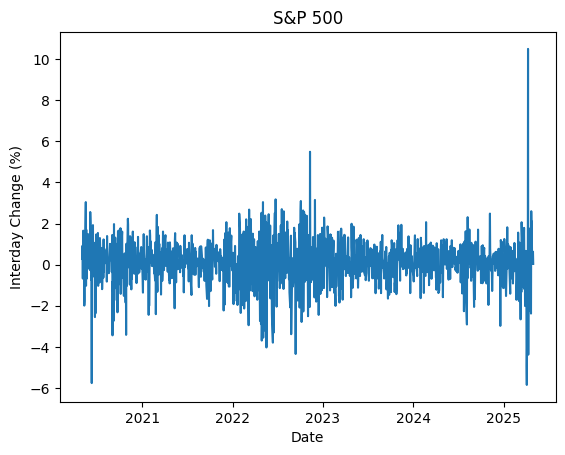

In [15]:
# graphing % change
historical = historical.reset_index()
X = pd.to_datetime(historical['Date'])
y = historical['Change']

plt.plot(X, y)
plt.title('S&P 500')
plt.xlabel('Date')
plt.ylabel('Interday Change (%)')
plt.show()


In [16]:
# EDA

historical.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,Change
count,1256.000000,1256.000000,1256.000000,1256.000000,1.256000e+03,1256.000000,1256.0,1256.0,1255.000000
mean,428.948228,431.479370,426.183817,429.023810,7.648009e+07,0.025251,0.0,0.0,0.065861
std,82.271656,82.403961,82.050493,82.268528,3.054595e+07,0.199954,0.0,0.0,1.130592
min,259.361937,263.964255,253.820432,261.825745,2.604870e+07,0.000000,0.0,0.0,-5.854297
25%,375.441971,378.725566,372.377102,375.508682,5.566398e+07,0.000000,0.0,0.0,-0.497928
50%,414.638230,417.952220,412.336218,415.468765,7.179025e+07,0.000000,0.0,0.0,0.090007
75%,480.128385,481.504051,478.088293,480.691956,9.082678e+07,0.000000,0.0,0.0,0.708139
max,609.705872,611.390763,607.731787,611.091675,2.566114e+08,1.966000,0.0,0.0,10.501930


# Finnhub API

In [18]:
# finnhub news api. allows for historical search

finnhub_client = finnhub.Client(api_key=finhubkey)

news = finnhub_client.company_news('SPY', _from="2025-04-01", to="2025-04-01")

# for i in news:
#   print(i['headline'])
for i in news:
  sentiment = finbert(i['summary'])
  if sentiment[0]['label'] == 'neutral':
    continue
  print(i['summary'], sentiment)

Stocks ended mostly higher today, though not in any inspiring fashion - more like the way a snake clears a hurdle. [{'label': 'positive', 'score': 0.8160881996154785}]
Expectations are building for a Fed interest rate cut. [{'label': 'positive', 'score': 0.7386780977249146}]
The S&P 500 and Nasdaq indices have breached March lows, while the Dow Jones remains resilient. Click here to find out more on Market Outlook. [{'label': 'negative', 'score': 0.7389934659004211}]
Tariffs are meant to reinvigorate US manufacturing but there's concern about what they mean for supply chains and the prospect of foreign retaliation amid signs of a cooling domestic economy [{'label': 'negative', 'score': 0.951738715171814}]
The iShares S&P GSCI Commodity-Indexed Trust rose 2.6%, posting Marchâs strongest return. Click to read. [{'label': 'positive', 'score': 0.9404349327087402}]
There are many reasons to think that the blunder of erecting a high import tariff wall will cause an economic recession not o